In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import keras
import time
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

Using TensorFlow backend.


In [2]:
#read data from csv file
dat=pd.read_csv('Book3.csv')
print(dat.head())

                    Date  Hour  DryBulb  DewPnt  SYSLoad   NumDate
0  2004-01-01 00:00:00.0     1       37      25    12230  732000.0
1  2004-01-01 00:00:00.0     2       37      25    11534  732000.0
2  2004-01-01 00:00:00.0     3       39      24    11038  732000.0
3  2004-01-01 00:00:00.0     4       38      22    10777  732000.0
4  2004-01-01 00:00:00.0     5       37      20    10764  732000.0


In [3]:
hdata=pd.read_excel('Holidays.xls')
hdata.dtypes

Date       datetime64[ns]
Holiday            object
dtype: object

In [4]:
holidays=hdata.Date
holidays.head()

0   2004-01-01
1   2004-01-19
2   2004-02-16
3   2004-05-31
4   2004-07-05
Name: Date, dtype: datetime64[ns]

In [5]:
dat['Date']=pd.to_datetime(dat['Date'])
dat.dtypes

Date       datetime64[ns]
Hour                int64
DryBulb             int64
DewPnt              int64
SYSLoad             int64
NumDate           float64
dtype: object

In [6]:
dayofweek=dat.Date.dt.weekday
dayofweek.head()

0    3
1    3
2    3
3    3
4    3
Name: Date, dtype: int64

In [7]:
isworkday = np.in1d(dayofweek,[0,1,2,3,4]) & ~np.in1d(dat['Date'],holidays)
isworkday[22]

False

In [8]:
import scipy
import scipy.signal
#By using the lfilter method get the previous 24 hour averrage temperature 
prev24houravg = scipy.signal.lfilter(np.ones(24) / 24, 1, dat['SYSLoad'])
prev24houravg.shape

(52608,)

In [9]:
prevweeksamehour=np.hstack(((np.ones(168)*-1),(dat['SYSLoad'][167:-1])))
prevweeksamehour.shape

(52608,)

In [10]:
prevdaysamehour=np.hstack(((np.ones(24)*-1),(dat['SYSLoad'][23:-1])))
prevdaysamehour.shape

(52608,)

In [25]:
def split_inputs(data):
    trainInd = dat.Date < dt.datetime(2008, 1, 1) 
    train = data[trainInd,:]
    train= train[168:,:]
    valid=data[35064:43848]
    return train, valid

In [26]:
#combine both output in the first column and inputs in the next 8 columns
data = np.vstack((dat['SYSLoad'],dat['DryBulb'],dat['DewPnt'],dat['Hour'],dayofweek,isworkday,prevweeksamehour,prevdaysamehour,prev24houravg))
data=np.transpose(data)
data.shape

(52608, 9)

In [27]:
train, valid = split_inputs(data)

In [28]:
# organize the data into inputs of size n_rows x 8 and outputs 1 x n_rows. Each LSTM cell will ouput a value for that timestep
# and the value will be compared with the expected output in order to decide the optimal number of LSTM cells 
def organize_data(data, n_rows):
    # flatten data
    X, y = list(), list()
    start = 0
    # organize each input in the set
    for _ in range(len(data)):
        #define the last row of the input
        end = start + n_rows

        # check that we havent reached the end of the dataset
        if end <= len(data):
            X.append(data[start:end, 1:n_rows])
            y.append(data[start:end, 0])
        # move to next input
        start += 1
    return np.array(X), np.array(y)

In [30]:
#define the number of timesteps or rows that will be in each input
n_inputs=12
train_x,train_y = organize_data(train,n_inputs)
valid_x,valid_y = organize_data(valid,n_inputs)

In [16]:
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
# define model
model = Sequential()
#Each LSTM cell will have an output then go through a dense layer of size 50
model.add(LSTM(50, activation='relu', input_shape=(n_timesteps, n_features),return_sequences=True))
model.add(Dense(50,activation='relu'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')


Instructions for updating:
Colocations handled automatically by placer.


In [17]:
start_time = time.time()
model.fit(train_x, train_y, epochs=55, batch_size=250, verbose=1)
time.time() - start_time

Instructions for updating:
Use tf.cast instead.
Epoch 1/55
34885/34885 [==============================] - 8s 239us/step - loss: 4602.2450
Epoch 2/55
34885/34885 [==============================] - 4s 115us/step - loss: 1596.4854
Epoch 3/55
34885/34885 [==============================] - 4s 119us/step - loss: 892.4307
Epoch 4/55
34885/34885 [==============================] - 4s 128us/step - loss: 646.4742 0s - loss
Epoch 5/55
34885/34885 [==============================] - 5s 131us/step - loss: 575.3895
Epoch 6/55
34885/34885 [==============================] - 4s 112us/step - loss: 530.1737
Epoch 7/55
34885/34885 [==============================] - 4s 112us/step - loss: 497.1620
Epoch 8/55
34885/34885 [==============================] - 4s 114us/step - loss: 467.0949
Epoch 9/55
34885/34885 [==============================] - 4s 118us/step - loss: 443.3807
Epoch 10/55
34885/34885 [==============================] - 4s 111us/step - loss: 437.5773
Epoch 11/55
34885/34885 [========================

258.0529975891113

In [18]:
predictions=model.predict(valid_x)

In [19]:
valid_y = valid_y.reshape((valid_y.shape[0], valid_y.shape[1],1))
error=valid_y-predictions
mae=np.mean(np.absolute(error))
mae

255.71885949640708

In [20]:
errorpercent=np.absolute(error)/valid_y
mape=np.mean(errorpercent)*100
mape

1.7020941436606616

In [21]:
error = error.reshape((error.shape[0], error.shape[1]))
valid_y = valid_y.reshape((valid_y.shape[0], valid_y.shape[1]))
#calculate the error for each output individually
e=pd.DataFrame(100*np.absolute(error)/valid_y)
#average the error of each column in order to see what number of LSTM cells works best 
p=e.mean(axis=0)-1
e.shape

(8773, 12)

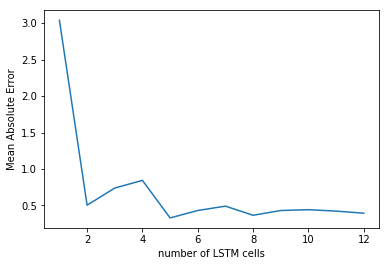

In [23]:
import matplotlib.pyplot as plt
x=list(range(1,13))
y=p
plt.plot(x,y)
plt.xlabel('number of LSTM cells')
plt.ylabel('Mean Absolute Error')
plt.show()